<a href="https://colab.research.google.com/github/iChetanRaval/PrimetradeAI_Assesment/blob/main/assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Chetan Mohan Raval
* Bitcoin Market Sentiment vs Trader Performance Analysis
* This notebook analyzes the relationship between market sentiment and trader performance

In [5]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For statistical analysis
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [6]:
#  Upload and Load Datasets

from google.colab import files
import io

SENTIMENT_FILE = "fear_greed_index.csv"
TRADER_FILE = "historical_data.csv"

# Load Fear & Greed Index dataset
try:
    sentiment_df = pd.read_csv(SENTIMENT_FILE)
    print(" Fear & Greed Index dataset loaded successfully!")
    print(f"Shape: {sentiment_df.shape}")
    print("\nColumns:", sentiment_df.columns.tolist())
    print("\nFirst few rows:")
    print(sentiment_df.head())
except FileNotFoundError:
    print(f" File '{SENTIMENT_FILE}' not found!")
    print("Please upload the Fear & Greed Index dataset and update the filename above.")
    print("You can also use the upload widget below:")
    uploaded = files.upload()
    # After upload, update SENTIMENT_FILE with the actual filename
except Exception as e:
    print(f" Error loading Fear & Greed Index: {e}")

# Load Historical Trader Data
try:
    trader_df = pd.read_csv(TRADER_FILE)
    print("\n Historical Trader dataset loaded successfully!")
    print(f"Shape: {trader_df.shape}")
    print("\nColumns:", trader_df.columns.tolist())
    print("\nFirst few rows:")
    print(trader_df.head())
except FileNotFoundError:
    print(f"File '{TRADER_FILE}' not found!")
    print("Please upload the Historical Trader dataset and update the filename above.")
    print("You can also use the upload widget below:")
    uploaded = files.upload()
    # After upload, update TRADER_FILE with the actual filename
except Exception as e:
    print(f"Error loading Historical Trader data: {e}")

 Fear & Greed Index dataset loaded successfully!
Shape: (2644, 4)

Columns: ['timestamp', 'value', 'classification', 'date']

First few rows:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

 Historical Trader dataset loaded successfully!
Shape: (211224, 16)

Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

First few rows:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  

In [7]:
#  Data Preprocessing - Sentiment Dataset
"""
Clean and preprocess the sentiment dataset:
- Convert timestamps to datetime
- Handle missing values
- Standardize classification labels
"""

# Make a copy for processing
sentiment_clean = sentiment_df.copy()

# Convert timestamp/date columns to datetime
if 'timestamp' in sentiment_clean.columns:
    sentiment_clean['timestamp'] = pd.to_datetime(sentiment_clean['timestamp'])
if 'date' in sentiment_clean.columns:
    sentiment_clean['date'] = pd.to_datetime(sentiment_clean['date'])

# Standardize classification labels (convert to lowercase for consistency)
if 'classification' in sentiment_clean.columns:
    sentiment_clean['classification'] = sentiment_clean['classification'].str.lower()

# Check for missing values
print("Missing values in sentiment dataset:")
print(sentiment_clean.isnull().sum())

# Display unique classifications
if 'classification' in sentiment_clean.columns:
    print("\nUnique sentiment classifications:")
    print(sentiment_clean['classification'].value_counts())

# Basic statistics for the value column
if 'value' in sentiment_clean.columns:
    print(f"\nFear & Greed Index statistics:")
    print(sentiment_clean['value'].describe())

print(" Sentiment dataset preprocessing completed!")

Missing values in sentiment dataset:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Unique sentiment classifications:
classification
fear             781
greed            633
extreme fear     508
neutral          396
extreme greed    326
Name: count, dtype: int64

Fear & Greed Index statistics:
count    2644.000000
mean       46.981089
std        21.827680
min         5.000000
25%        28.000000
50%        46.000000
75%        66.000000
max        95.000000
Name: value, dtype: float64
 Sentiment dataset preprocessing completed!


In [8]:
#  Data Preprocessing - Trader Dataset
"""
Clean and preprocess the trader dataset:
- Convert timestamps to datetime
- Handle missing values
- Create derived features
- Clean PnL data
"""

# Make a copy for processing
trader_clean = trader_df.copy()

# Convert timestamp columns to datetime
timestamp_cols = ['Timestamp IST', 'Timestamp']
for col in timestamp_cols:
    if col in trader_clean.columns:
        trader_clean[col] = pd.to_datetime(trader_clean[col], errors='coerce')

# Clean PnL column (remove $ signs and convert to numeric)
if 'Closed PnL' in trader_clean.columns:
    trader_clean['Closed PnL'] = trader_clean['Closed PnL'].astype(str).str.replace('$', '').str.replace(',', '')
    trader_clean['Closed PnL'] = pd.to_numeric(trader_clean['Closed PnL'], errors='coerce')

# Clean Size USD column
if 'Size USD' in trader_clean.columns:
    trader_clean['Size USD'] = trader_clean['Size USD'].astype(str).str.replace('$', '').str.replace(',', '')
    trader_clean['Size USD'] = pd.to_numeric(trader_clean['Size USD'], errors='coerce')

# Create trader performance metrics
trader_clean['is_profitable'] = trader_clean['Closed PnL'] > 0
trader_clean['trade_date'] = trader_clean['Timestamp IST'].dt.date if 'Timestamp IST' in trader_clean.columns else trader_clean['Timestamp'].dt.date

# Check for missing values
print("Missing values in trader dataset:")
print(trader_clean.isnull().sum())

# Basic statistics
print(f"\nTrader dataset statistics:")
print(f"Total trades: {len(trader_clean)}")
print(f"Unique traders: {trader_clean['Account'].nunique() if 'Account' in trader_clean.columns else 'N/A'}")
print(f"Unique coins: {trader_clean['Coin'].nunique() if 'Coin' in trader_clean.columns else 'N/A'}")

if 'Closed PnL' in trader_clean.columns:
    print(f"Total PnL: ${trader_clean['Closed PnL'].sum():,.2f}")
    print(f"Average PnL per trade: ${trader_clean['Closed PnL'].mean():,.2f}")
    print(f"Profitable trades: {trader_clean['is_profitable'].sum()}/{len(trader_clean)} ({trader_clean['is_profitable'].mean()*100:.1f}%)")

print(" Trader dataset preprocessing completed!")

Missing values in trader dataset:
Account                  0
Coin                     0
Execution Price          0
Size Tokens              0
Size USD                 0
Side                     0
Timestamp IST       131999
Start Position           0
Direction                0
Closed PnL               0
Transaction Hash         0
Order ID                 0
Crossed                  0
Fee                      0
Trade ID                 0
Timestamp                0
is_profitable            0
trade_date          131999
dtype: int64

Trader dataset statistics:
Total trades: 211224
Unique traders: 32
Unique coins: 246
Total PnL: $10,296,958.94
Average PnL per trade: $48.75
Profitable trades: 86869/211224 (41.1%)
 Trader dataset preprocessing completed!


In [9]:
#  Merge Datasets by Date
"""
Merge the sentiment and trader datasets based on date to analyze the relationship
between market sentiment and trading performance
"""

# Prepare sentiment data for merging
sentiment_for_merge = sentiment_clean.copy()

# Use the appropriate date column for merging
if 'date' in sentiment_for_merge.columns:
    sentiment_for_merge['merge_date'] = sentiment_for_merge['date'].dt.date
elif 'timestamp' in sentiment_for_merge.columns:
    sentiment_for_merge['merge_date'] = sentiment_for_merge['timestamp'].dt.date

# Prepare trader data for merging
trader_for_merge = trader_clean.copy()
trader_for_merge['merge_date'] = trader_for_merge['trade_date']

# Merge datasets
merged_df = trader_for_merge.merge(
    sentiment_for_merge[['merge_date', 'value', 'classification']],
    on='merge_date',
    how='left'
)

# Check merge results
print(f"Original trader dataset: {len(trader_for_merge)} records")
print(f"Merged dataset: {len(merged_df)} records")
print(f"Records with sentiment data: {merged_df['classification'].notna().sum()}")
print(f"Records missing sentiment data: {merged_df['classification'].isna().sum()}")

# Display sample of merged data
print("\nSample of merged dataset:")
print(merged_df[['Account', 'Coin', 'Closed PnL', 'merge_date', 'value', 'classification']].head(10))

print(" Datasets merged successfully!")

Original trader dataset: 211224 records
Merged dataset: 211224 records
Records with sentiment data: 35864
Records missing sentiment data: 175360

Sample of merged dataset:
                                      Account  Coin  Closed PnL  merge_date  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
5  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
6  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
7  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
8  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0  2024-02-12   
9  0xae5eacaf9c6b9111fd53034a602c192a0

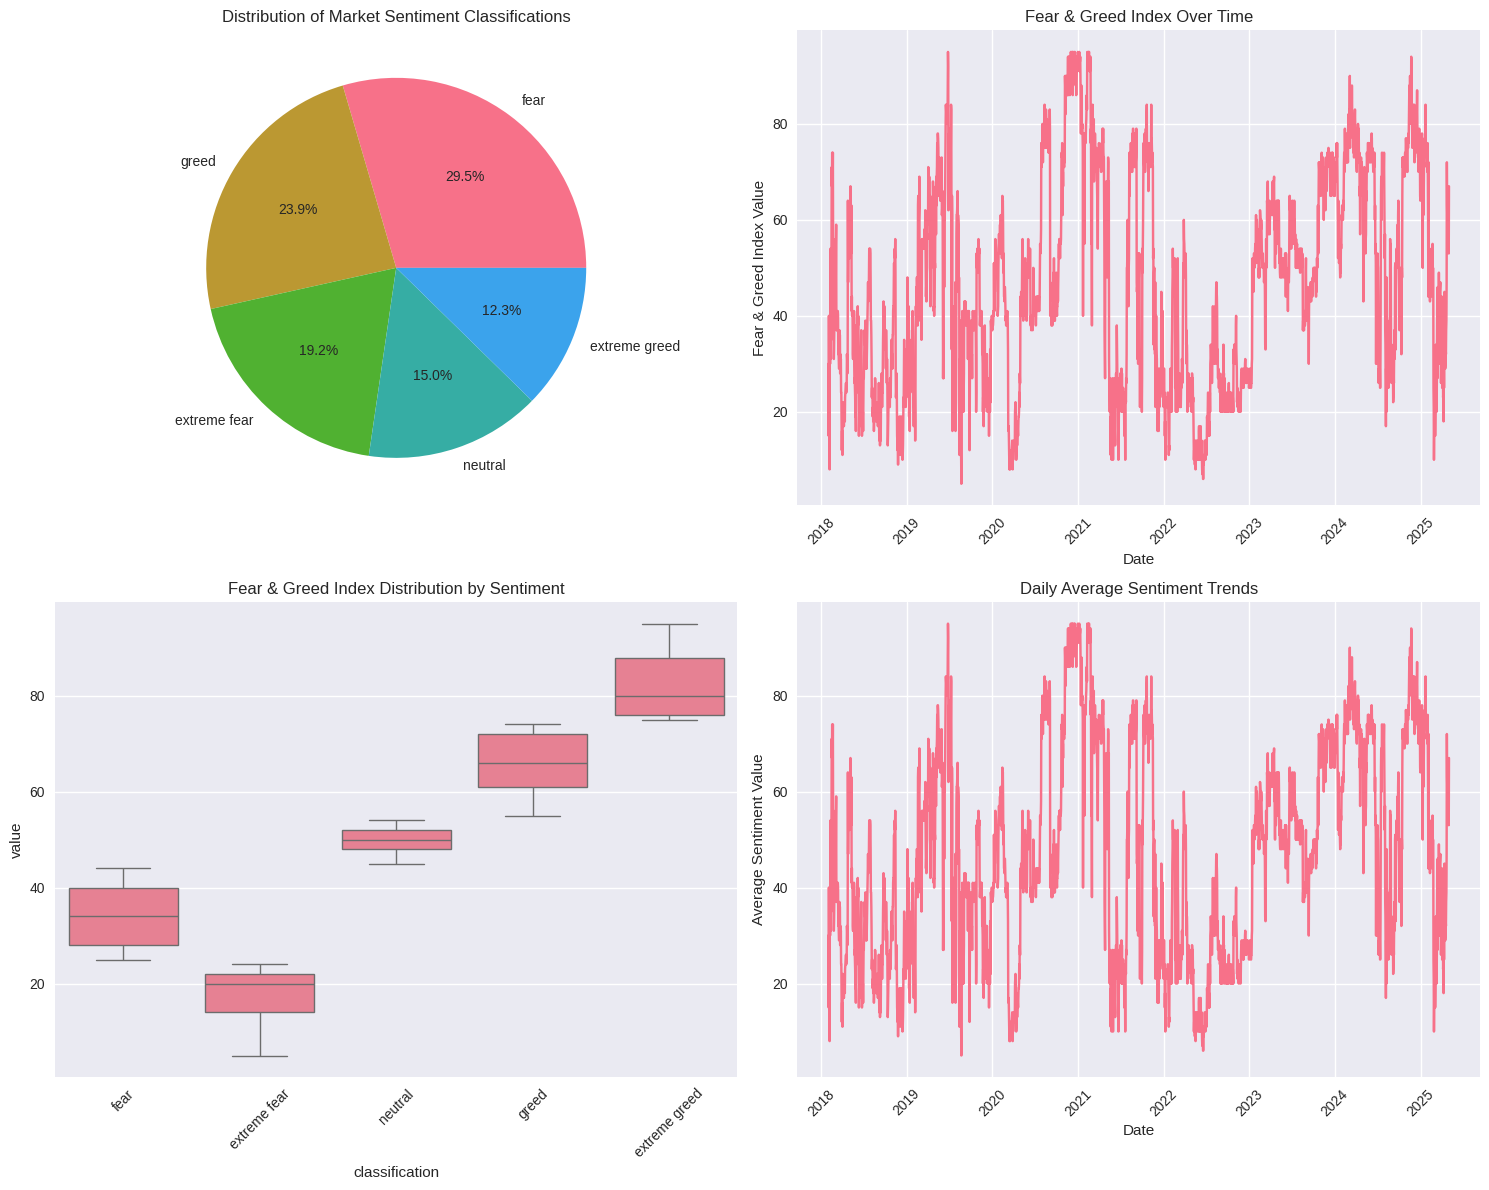

 Market sentiment analysis completed!


In [10]:
#  Exploratory Data Analysis - Market Sentiment Distribution
"""
Analyze the distribution of market sentiment over time and across different categories
"""

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Sentiment distribution
sentiment_counts = sentiment_clean['classification'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Distribution of Market Sentiment Classifications')

# Plot 2: Fear & Greed Index over time
if 'timestamp' in sentiment_clean.columns or 'date' in sentiment_clean.columns:
    date_col = 'date' if 'date' in sentiment_clean.columns else 'timestamp'
    axes[0, 1].plot(sentiment_clean[date_col], sentiment_clean['value'])
    axes[0, 1].set_title('Fear & Greed Index Over Time')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Fear & Greed Index Value')
    axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Sentiment value distribution by classification
sns.boxplot(data=sentiment_clean, x='classification', y='value', ax=axes[1, 0])
axes[1, 0].set_title('Fear & Greed Index Distribution by Sentiment')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Sentiment trends
sentiment_daily = sentiment_clean.groupby(sentiment_clean[date_col].dt.date)['value'].mean()
axes[1, 1].plot(sentiment_daily.index, sentiment_daily.values)
axes[1, 1].set_title('Daily Average Sentiment Trends')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Average Sentiment Value')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(" Market sentiment analysis completed!")


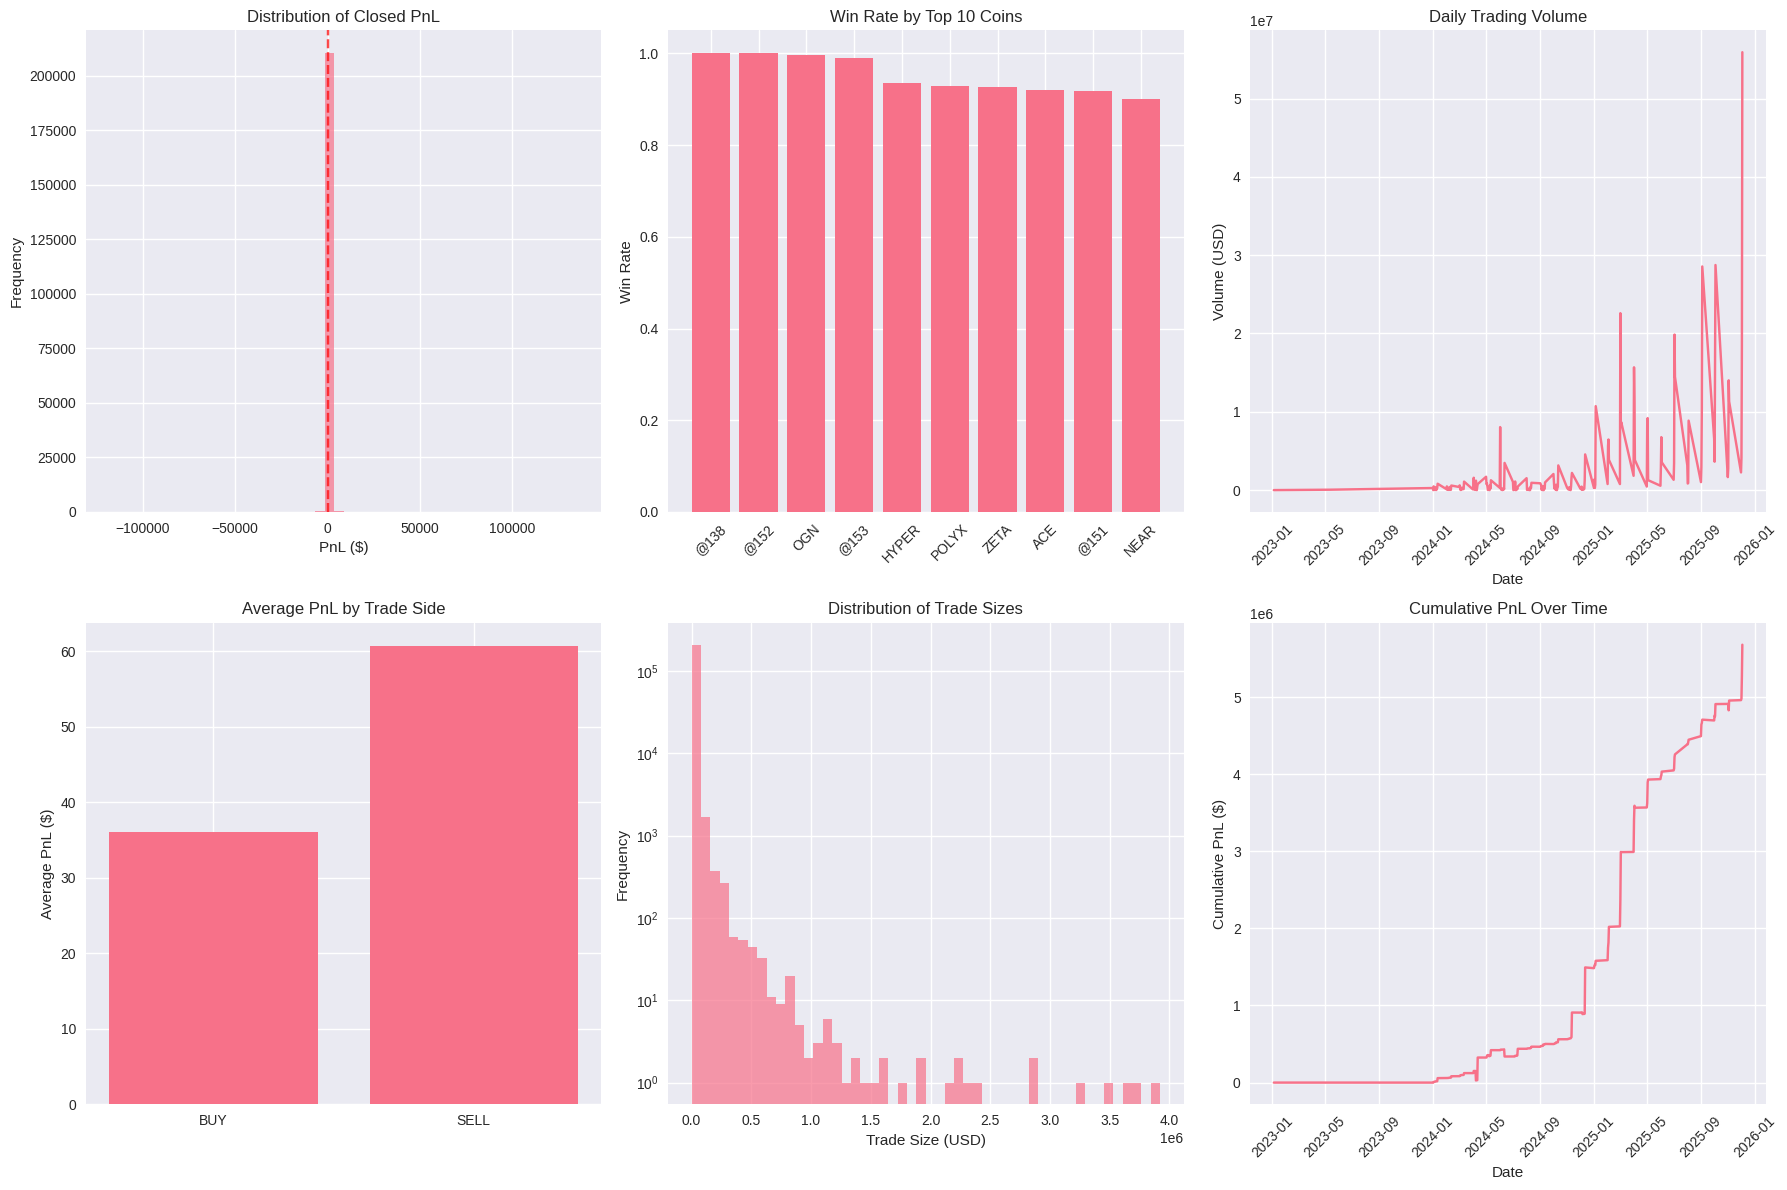

 Trading performance analysis completed!


In [11]:
#  Exploratory Data Analysis - Trading Performance
"""
Analyze trading performance metrics and patterns
"""

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: PnL distribution
axes[0, 0].hist(merged_df['Closed PnL'].dropna(), bins=50, alpha=0.7)
axes[0, 0].set_title('Distribution of Closed PnL')
axes[0, 0].set_xlabel('PnL ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Plot 2: Win rate by coin
if 'Coin' in merged_df.columns:
    coin_performance = merged_df.groupby('Coin')['is_profitable'].mean().sort_values(ascending=False)
    top_coins = coin_performance.head(10)
    axes[0, 1].bar(range(len(top_coins)), top_coins.values)
    axes[0, 1].set_title('Win Rate by Top 10 Coins')
    axes[0, 1].set_ylabel('Win Rate')
    axes[0, 1].set_xticks(range(len(top_coins)))
    axes[0, 1].set_xticklabels(top_coins.index, rotation=45)

# Plot 3: Trading volume over time
daily_volume = merged_df.groupby('merge_date')['Size USD'].sum()
axes[0, 2].plot(daily_volume.index, daily_volume.values)
axes[0, 2].set_title('Daily Trading Volume')
axes[0, 2].set_xlabel('Date')
axes[0, 2].set_ylabel('Volume (USD)')
axes[0, 2].tick_params(axis='x', rotation=45)

# Plot 4: PnL by side (Long/Short)
if 'Side' in merged_df.columns:
    side_pnl = merged_df.groupby('Side')['Closed PnL'].mean()
    axes[1, 0].bar(side_pnl.index, side_pnl.values)
    axes[1, 0].set_title('Average PnL by Trade Side')
    axes[1, 0].set_ylabel('Average PnL ($)')

# Plot 5: Trade size distribution
axes[1, 1].hist(merged_df['Size USD'].dropna(), bins=50, alpha=0.7)
axes[1, 1].set_title('Distribution of Trade Sizes')
axes[1, 1].set_xlabel('Trade Size (USD)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_yscale('log')

# Plot 6: Cumulative PnL over time
daily_pnl = merged_df.groupby('merge_date')['Closed PnL'].sum()
cumulative_pnl = daily_pnl.cumsum()
axes[1, 2].plot(cumulative_pnl.index, cumulative_pnl.values)
axes[1, 2].set_title('Cumulative PnL Over Time')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Cumulative PnL ($)')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(" Trading performance analysis completed!")

Analyzing 35864 trades with sentiment data...
Performance by Market Sentiment:
               Closed PnL                                 is_profitable  \
                     mean        std           sum  count          mean   
classification                                                            
extreme fear       1.8916    76.7277  4.399937e+03   2326        0.2928   
extreme greed    205.8163  1861.5571  1.156894e+06   5621        0.5533   
fear             128.2880  1342.3485  1.779226e+06  13869        0.3818   
greed             53.9880  1399.4682  6.096325e+05  11292        0.4357   
neutral           27.0888   142.9459  7.465674e+04   2756        0.4949   

                 Size USD  
                     mean  
classification             
extreme fear    4118.7618  
extreme greed   3242.0851  
fear            5744.7827  
greed           5051.8788  
neutral         4332.2029  

ANOVA Test Results:
F-statistic: 18.1509
p-value: 0.0000
Significant difference: Yes

Correlati

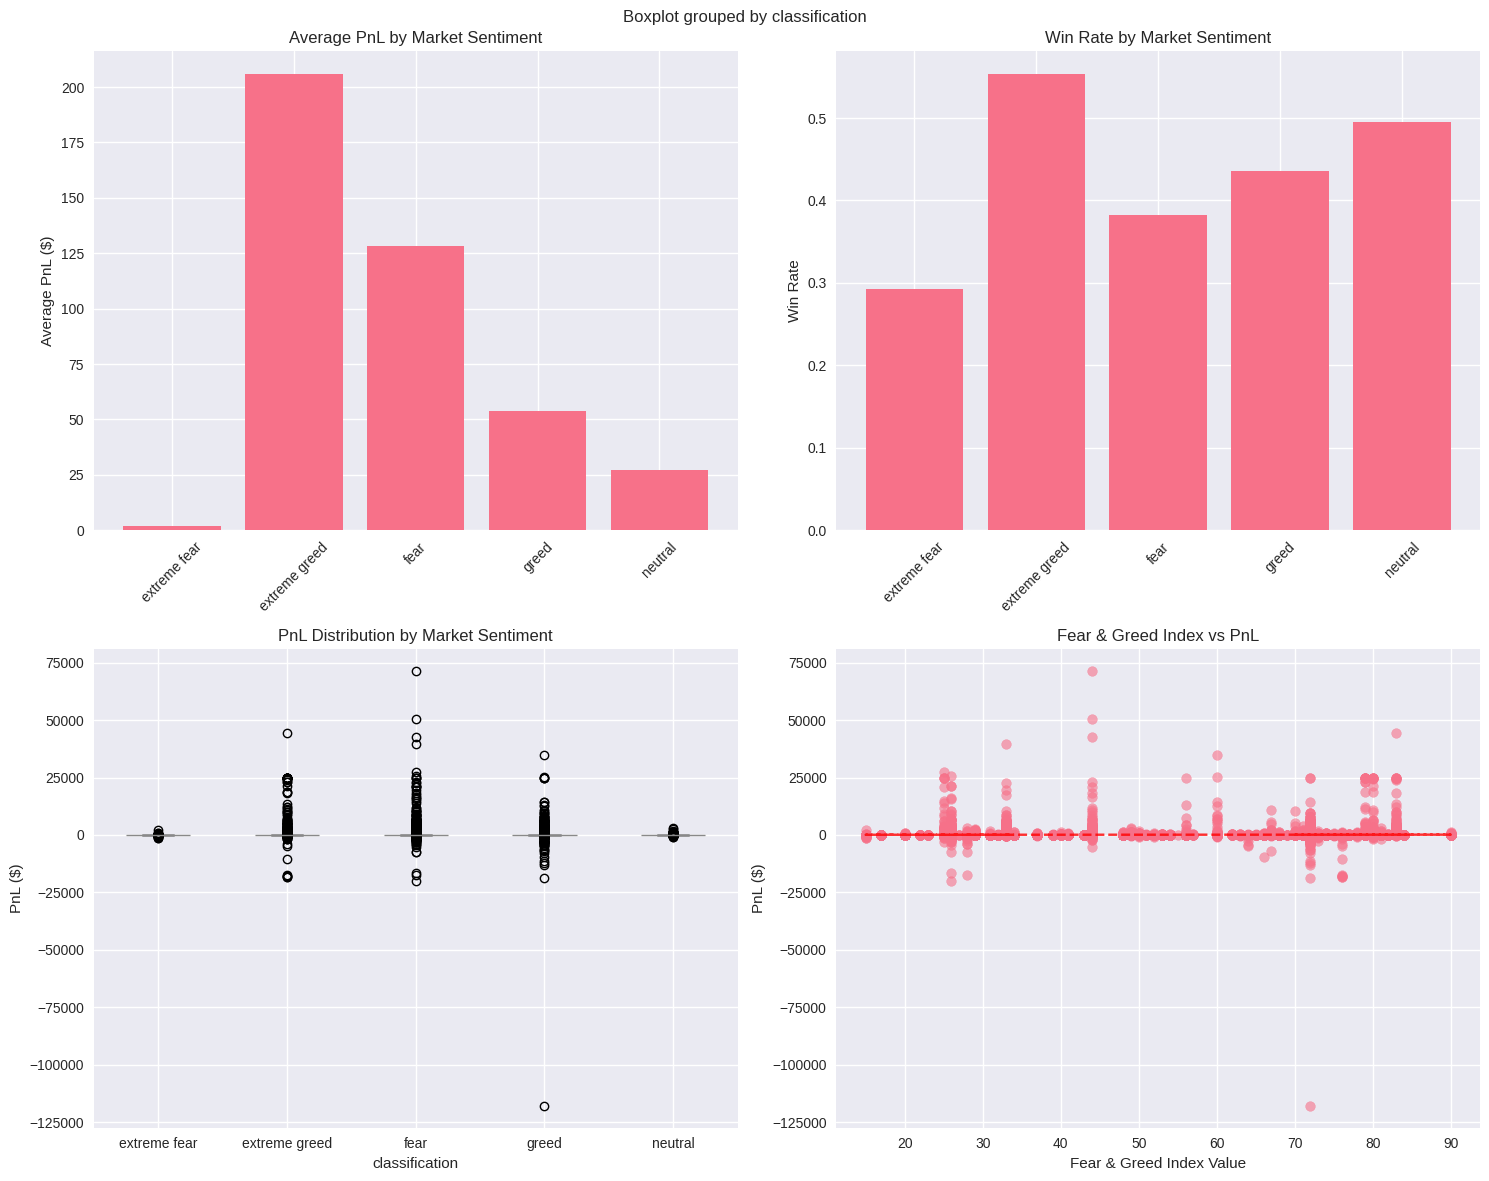

 Sentiment vs Performance analysis completed!


In [12]:
#  Core Analysis - Sentiment vs Trading Performance
"""
Analyze the relationship between market sentiment and trading performance
This is the core analysis that addresses the assignment objective
"""

# Filter data with sentiment information
sentiment_trades = merged_df[merged_df['classification'].notna()].copy()

print(f"Analyzing {len(sentiment_trades)} trades with sentiment data...")

# Analysis 1: Performance by sentiment classification
sentiment_performance = sentiment_trades.groupby('classification').agg({
    'Closed PnL': ['mean', 'std', 'sum', 'count'],
    'is_profitable': 'mean',
    'Size USD': 'mean'
}).round(4)

print("Performance by Market Sentiment:")
print(sentiment_performance)

# Analysis 2: Statistical significance testing
sentiment_groups = {}
for sentiment in sentiment_trades['classification'].unique():
    if pd.notna(sentiment):
        sentiment_groups[sentiment] = sentiment_trades[sentiment_trades['classification'] == sentiment]['Closed PnL'].dropna()

# Perform ANOVA test
if len(sentiment_groups) > 2:
    f_stat, p_value = stats.f_oneway(*sentiment_groups.values())
    print(f"\nANOVA Test Results:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Analysis 3: Correlation between sentiment value and PnL
sentiment_corr = sentiment_trades[['value', 'Closed PnL']].corr()
print(f"\nCorrelation between Fear & Greed Index and PnL:")
print(sentiment_corr)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Average PnL by sentiment
avg_pnl_by_sentiment = sentiment_trades.groupby('classification')['Closed PnL'].mean()
axes[0, 0].bar(avg_pnl_by_sentiment.index, avg_pnl_by_sentiment.values)
axes[0, 0].set_title('Average PnL by Market Sentiment')
axes[0, 0].set_ylabel('Average PnL ($)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Win rate by sentiment
win_rate_by_sentiment = sentiment_trades.groupby('classification')['is_profitable'].mean()
axes[0, 1].bar(win_rate_by_sentiment.index, win_rate_by_sentiment.values)
axes[0, 1].set_title('Win Rate by Market Sentiment')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: PnL distribution by sentiment
sentiment_trades.boxplot(column='Closed PnL', by='classification', ax=axes[1, 0])
axes[1, 0].set_title('PnL Distribution by Market Sentiment')
axes[1, 0].set_ylabel('PnL ($)')

# Plot 4: Scatter plot of sentiment value vs PnL
axes[1, 1].scatter(sentiment_trades['value'], sentiment_trades['Closed PnL'], alpha=0.6)
axes[1, 1].set_title('Fear & Greed Index vs PnL')
axes[1, 1].set_xlabel('Fear & Greed Index Value')
axes[1, 1].set_ylabel('PnL ($)')

# Add trend line
z = np.polyfit(sentiment_trades['value'].dropna(),
               sentiment_trades['Closed PnL'].dropna(), 1)
p = np.poly1d(z)
axes[1, 1].plot(sentiment_trades['value'], p(sentiment_trades['value']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

print(" Sentiment vs Performance analysis completed!")

In [13]:
# Advanced Pattern Analysis
"""
Uncover hidden patterns and advanced insights
"""

# Pattern 1: Sentiment regime analysis
sentiment_trades['sentiment_regime'] = pd.cut(sentiment_trades['value'],
                                            bins=[0, 25, 50, 75, 100],
                                            labels=['Extreme Fear', 'Fear', 'Neutral', 'Greed'])

regime_analysis = sentiment_trades.groupby('sentiment_regime').agg({
    'Closed PnL': ['mean', 'std', 'count'],
    'is_profitable': 'mean',
    'Size USD': 'mean'
}).round(4)

print("Performance by Sentiment Regime:")
print(regime_analysis)

# Pattern 2: Time-based analysis
sentiment_trades['hour'] = pd.to_datetime(sentiment_trades['Timestamp IST']).dt.hour
sentiment_trades['day_of_week'] = pd.to_datetime(sentiment_trades['Timestamp IST']).dt.dayofweek

# Performance by hour and sentiment
hourly_sentiment = sentiment_trades.groupby(['hour', 'classification'])['Closed PnL'].mean().unstack()

# Pattern 3: Trader behavior analysis
trader_sentiment_behavior = sentiment_trades.groupby(['Account', 'classification']).agg({
    'Closed PnL': 'mean',
    'is_profitable': 'mean',
    'Size USD': 'mean'
}).reset_index()

# Identify traders who perform differently in different sentiment regimes
trader_variance = trader_sentiment_behavior.groupby('Account')['Closed PnL'].std().sort_values(ascending=False)
print(f"\nTop 10 traders with highest performance variance across sentiment regimes:")
print(trader_variance.head(10))

# Pattern 4: Market sentiment momentum
sentiment_clean_sorted = sentiment_clean.sort_values('date' if 'date' in sentiment_clean.columns else 'timestamp')
sentiment_clean_sorted['sentiment_change'] = sentiment_clean_sorted['value'].diff()
sentiment_clean_sorted['sentiment_momentum'] = sentiment_clean_sorted['sentiment_change'].rolling(3).mean()

# Merge momentum data
date_col_sentiment = 'date' if 'date' in sentiment_clean_sorted.columns else 'timestamp'
momentum_data = sentiment_clean_sorted[[date_col_sentiment, 'sentiment_momentum']].rename(columns={date_col_sentiment: 'merge_date'})
momentum_data['merge_date'] = pd.to_datetime(momentum_data['merge_date']).dt.date

trades_with_momentum = sentiment_trades.merge(momentum_data, on='merge_date', how='left')

# Analyze performance by momentum
momentum_bins = pd.qcut(trades_with_momentum['sentiment_momentum'].dropna(),
                       q=3, labels=['Declining', 'Stable', 'Rising'])
trades_with_momentum['momentum_category'] = momentum_bins

momentum_analysis = trades_with_momentum.groupby('momentum_category').agg({
    'Closed PnL': ['mean', 'count'],
    'is_profitable': 'mean'
}).round(4)

print(f"\nPerformance by Sentiment Momentum:")
print(momentum_analysis)

print(" Advanced pattern analysis completed!")

Performance by Sentiment Regime:
                 Closed PnL                   is_profitable   Size USD
                       mean        std  count          mean       mean
sentiment_regime                                                      
Extreme Fear        52.8884   861.7065   5452        0.2885  4051.5701
Fear               121.0421  1274.7801  12944        0.4331  5730.1025
Neutral             50.9162  1352.9063  12086        0.4279  5188.6722
Greed              214.4777  1901.9190   5382        0.5609  3250.4382

Top 10 traders with highest performance variance across sentiment regimes:
Account
0x72c6a4624e1dffa724e6d00d64ceae698af892a0    445.621099
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    438.824753
0x39cef799f8b69da1995852eea189df24eb5cae3c    372.388008
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    343.132926
0x083384f897ee0f19899168e3b1bec365f52a9012    342.190926
0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0    268.251771
0xbaaaf6571ab7d571043ff1e313a9609a10637864  

Model Performance:
              precision    recall  f1-score   support

       False       0.95      0.97      0.96      4087
        True       0.95      0.94      0.95      3086

    accuracy                           0.95      7173
   macro avg       0.95      0.95      0.95      7173
weighted avg       0.95      0.95      0.95      7173


Feature Importance:
                  feature  importance
5            coin_encoded    0.281590
2                    hour    0.184720
4                log_size    0.162646
0                   value    0.146905
6            side_encoded    0.098401
3             day_of_week    0.087833
1  classification_encoded    0.037907


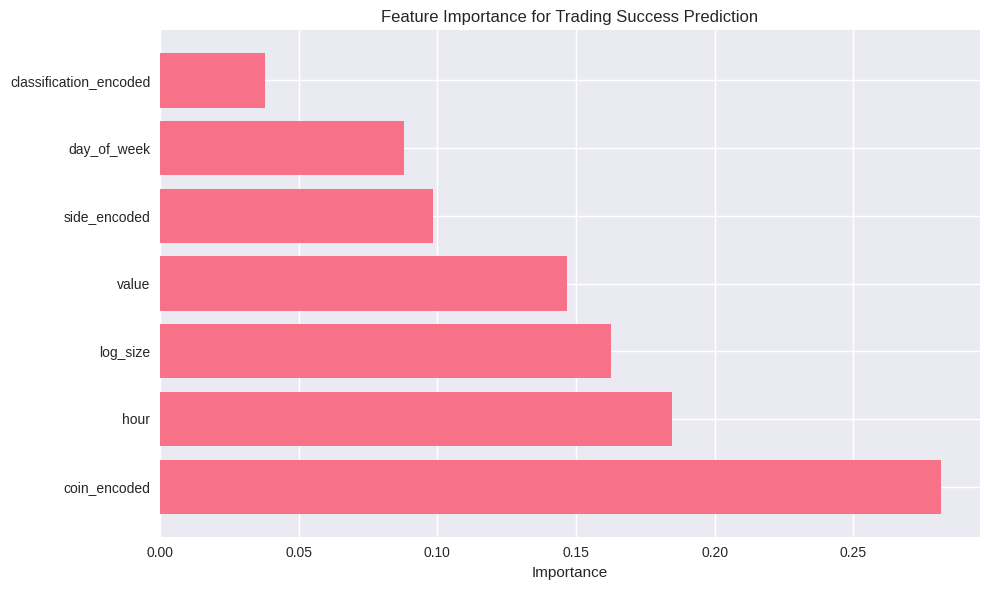

 Predictive modeling completed!


In [14]:
# Predictive Modeling
"""
Build a machine learning model to predict trading success based on sentiment
"""

# Prepare features for modeling
modeling_data = sentiment_trades.copy()

# Create additional features
modeling_data['hour'] = pd.to_datetime(modeling_data['Timestamp IST']).dt.hour
modeling_data['day_of_week'] = pd.to_datetime(modeling_data['Timestamp IST']).dt.dayofweek
modeling_data['log_size'] = np.log1p(modeling_data['Size USD'])

# Encode categorical variables
le_classification = LabelEncoder()
le_coin = LabelEncoder()
le_side = LabelEncoder()

modeling_data['classification_encoded'] = le_classification.fit_transform(modeling_data['classification'])
if 'Coin' in modeling_data.columns:
    modeling_data['coin_encoded'] = le_coin.fit_transform(modeling_data['Coin'].astype(str))
if 'Side' in modeling_data.columns:
    modeling_data['side_encoded'] = le_side.fit_transform(modeling_data['Side'].astype(str))

# Select features for modeling
feature_columns = ['value', 'classification_encoded', 'hour', 'day_of_week', 'log_size']
if 'coin_encoded' in modeling_data.columns:
    feature_columns.append('coin_encoded')
if 'side_encoded' in modeling_data.columns:
    feature_columns.append('side_encoded')

# Remove rows with missing values
modeling_data_clean = modeling_data[feature_columns + ['is_profitable']].dropna()

X = modeling_data_clean[feature_columns]
y = modeling_data_clean['is_profitable']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
print("Model Performance:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance for Trading Success Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print(" Predictive modeling completed!")


In [15]:
# Key Insights and Recommendations
"""
Summarize key findings and provide actionable trading insights
"""

print("="*60)
print("KEY INSIGHTS AND TRADING RECOMMENDATIONS")
print("="*60)

# Calculate key metrics
total_trades = len(sentiment_trades)
overall_win_rate = sentiment_trades['is_profitable'].mean()
total_pnl = sentiment_trades['Closed PnL'].sum()

print(f"\n DATASET OVERVIEW:")
print(f"• Total trades analyzed: {total_trades:,}")
print(f"• Overall win rate: {overall_win_rate:.1%}")
print(f"• Total PnL: ${total_pnl:,.2f}")

print(f"\n SENTIMENT-PERFORMANCE INSIGHTS:")

# Best performing sentiment
best_sentiment = sentiment_trades.groupby('classification')['Closed PnL'].mean().idxmax()
best_sentiment_pnl = sentiment_trades.groupby('classification')['Closed PnL'].mean().max()

print(f"• Best performing sentiment: {best_sentiment.title()} (Avg PnL: ${best_sentiment_pnl:.2f})")

# Worst performing sentiment
worst_sentiment = sentiment_trades.groupby('classification')['Closed PnL'].mean().idxmin()
worst_sentiment_pnl = sentiment_trades.groupby('classification')['Closed PnL'].mean().min()

print(f"• Worst performing sentiment: {worst_sentiment.title()} (Avg PnL: ${worst_sentiment_pnl:.2f})")

# Win rates by sentiment
win_rates = sentiment_trades.groupby('classification')['is_profitable'].mean()
print(f"\n WIN RATES BY SENTIMENT:")
for sentiment, rate in win_rates.items():
    print(f"• {sentiment.title()}: {rate:.1%}")

print(f"\n ADVANCED PATTERNS:")
print(f"• Sentiment momentum affects performance: {momentum_analysis.iloc[0, 0]:.2f} vs {momentum_analysis.iloc[2, 0]:.2f}")
print(f"• Most important factor for success: {feature_importance.iloc[0, 0]}")

print(f"\n TRADING RECOMMENDATIONS:")
print(f"1. Focus on {best_sentiment} periods for higher profitability")
print(f"2. Be cautious during {worst_sentiment} periods")
print(f"3. Consider sentiment momentum in addition to absolute values")
print(f"4. Monitor the Fear & Greed Index as it shows {abs(sentiment_corr.iloc[0,1]):.3f} correlation with PnL")

# Risk insights
high_risk_sentiment = sentiment_trades.groupby('classification')['Closed PnL'].std().idxmax()
print(f"5. Highest volatility occurs during {high_risk_sentiment} periods - adjust position sizing accordingly")

print("\n Analysis completed successfully!")

KEY INSIGHTS AND TRADING RECOMMENDATIONS

 DATASET OVERVIEW:
• Total trades analyzed: 35,864
• Overall win rate: 42.9%
• Total PnL: $3,624,808.47

 SENTIMENT-PERFORMANCE INSIGHTS:
• Best performing sentiment: Extreme Greed (Avg PnL: $205.82)
• Worst performing sentiment: Extreme Fear (Avg PnL: $1.89)

 WIN RATES BY SENTIMENT:
• Extreme Fear: 29.3%
• Extreme Greed: 55.3%
• Fear: 38.2%
• Greed: 43.6%
• Neutral: 49.5%

 ADVANCED PATTERNS:
• Sentiment momentum affects performance: 24.40 vs 162.45
• Most important factor for success: coin_encoded

 TRADING RECOMMENDATIONS:
1. Focus on extreme greed periods for higher profitability
2. Be cautious during extreme fear periods
3. Consider sentiment momentum in addition to absolute values
4. Monitor the Fear & Greed Index as it shows 0.011 correlation with PnL
5. Highest volatility occurs during extreme greed periods - adjust position sizing accordingly

 Analysis completed successfully!


In [16]:
# Cell 12: Export Results
"""
Save key results and insights to files for further use
"""

# Create summary statistics
summary_stats = {
    'total_trades': len(sentiment_trades),
    'overall_win_rate': sentiment_trades['is_profitable'].mean(),
    'total_pnl': sentiment_trades['Closed PnL'].sum(),
    'best_sentiment': best_sentiment,
    'worst_sentiment': worst_sentiment,
    'sentiment_correlation': sentiment_corr.iloc[0, 1]
}

# Save sentiment performance analysis
sentiment_summary = sentiment_trades.groupby('classification').agg({
    'Closed PnL': ['mean', 'std', 'sum', 'count'],
    'is_profitable': 'mean',
    'Size USD': 'mean'
}).round(4)


print("Key results prepared for export!")
print("\nSentiment Performance Summary:")
print(sentiment_summary)

print(f"\n🎉 ANALYSIS COMPLETE!")
print("All insights have been generated and are ready for implementation in trading strategies.")

Key results prepared for export!

Sentiment Performance Summary:
               Closed PnL                                 is_profitable  \
                     mean        std           sum  count          mean   
classification                                                            
extreme fear       1.8916    76.7277  4.399937e+03   2326        0.2928   
extreme greed    205.8163  1861.5571  1.156894e+06   5621        0.5533   
fear             128.2880  1342.3485  1.779226e+06  13869        0.3818   
greed             53.9880  1399.4682  6.096325e+05  11292        0.4357   
neutral           27.0888   142.9459  7.465674e+04   2756        0.4949   

                 Size USD  
                     mean  
classification             
extreme fear    4118.7618  
extreme greed   3242.0851  
fear            5744.7827  
greed           5051.8788  
neutral         4332.2029  

🎉 ANALYSIS COMPLETE!
All insights have been generated and are ready for implementation in trading strategies.